In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import time as ti
import loompy as lp
import pandas as pd

import pickle
import multiprocessing
from multiprocessing import Pool

# Scientific computing imports
import numpy as np
from numpy.fft import irfftn
from numpy.random import choice
from scipy.stats import rv_discrete, poisson, nbinom, gaussian_kde
import matplotlib.pyplot as plt

import scipy 
from scipy import integrate

# Scientific computing imports
import pymc as pm
import pytensor.tensor as tt

# Plotting
import matplotlib.pyplot as plt
import arviz as az
import matplotlib as mpl

In [2]:
class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, mx, data, likelihood):
        
        # add inputs as class attributes
        self.mx = mx
        self.data = data
        self.likelihood = likelihood
        
    def perform(self, node, inputs, outputs):
        
        phi, = inputs # this contains parmeters
        logl = self.likelihood(phi, self.mx, self.data) # calls the log-likelihood function
        outputs[0][0] = np.array(logl) # output the log-likelihood

# Simulations

In [15]:
from bioscrape.simulator import py_simulate_model
from bioscrape.types import Model
#Create a list of species names (strings)
species = ["G0", "G1", "U", "S", "C", "P"]

#create a list of parameters in the form (param_name[string], param_val[number])
kon = 10.0
koff = 10.0
k = 20.0
beta = 10.0
gamma = 2.0
delta = 2.0
k_p = 10
gamma_p = 0.1

#create reaction tuples with delays require additional elements. They are of the form:
#(Inputs[string list], Outputs[string list], propensity_type[string], propensity_dict {propensity_param:model_param},
# delay_type[string], DelayInputs [string list], DelayOutputs [string list], delay_param_dictionary {delay_param:model_param}).

rxn1 = (["G0"], ["G1"], "massaction", {"k":kon})
rxn2 = (["G1"], ["G0"], "massaction", {"k":koff})
rxn3 = (["G1"], ["G1","U"], "massaction", {"k":k})
#rxn3d = (["G1"], ["G1"], "massaction", {"k":alpha},"fixed", [], ["N"], {"delay":delay_alpha})
rxn4 = (["U"], ["S"], "massaction", {"k":beta})
rxn5 = (["S"], ["C"], "massaction", {"k":delta})
rxn6 = (["C"], [], "massaction", {"k":gamma})
rxn7 = (["C"], ["C","P"], "massaction", {"k":k_p})
rxn8 = (["P"], [], "massaction", {"k":gamma_p})
#Reactions 3 and 4 remain unchanged
rxns = [rxn1, rxn2, rxn3, rxn4, rxn5, rxn6, rxn7, rxn8]
x0 = {"G0":2,"G1":0,"U":2,"S":10,"C":10,"P":1000}

#Instaniate the Model object, species, params, and x0 remain unchanged from the previous example
model = Model(species = species, reactions = rxns, initial_condition_dict = x0)

#Simulate the Model with delay
timepoints = np.arange(0, 100000, 1e-2)
results = py_simulate_model(timepoints, Model = model, stochastic = True, delay = True)

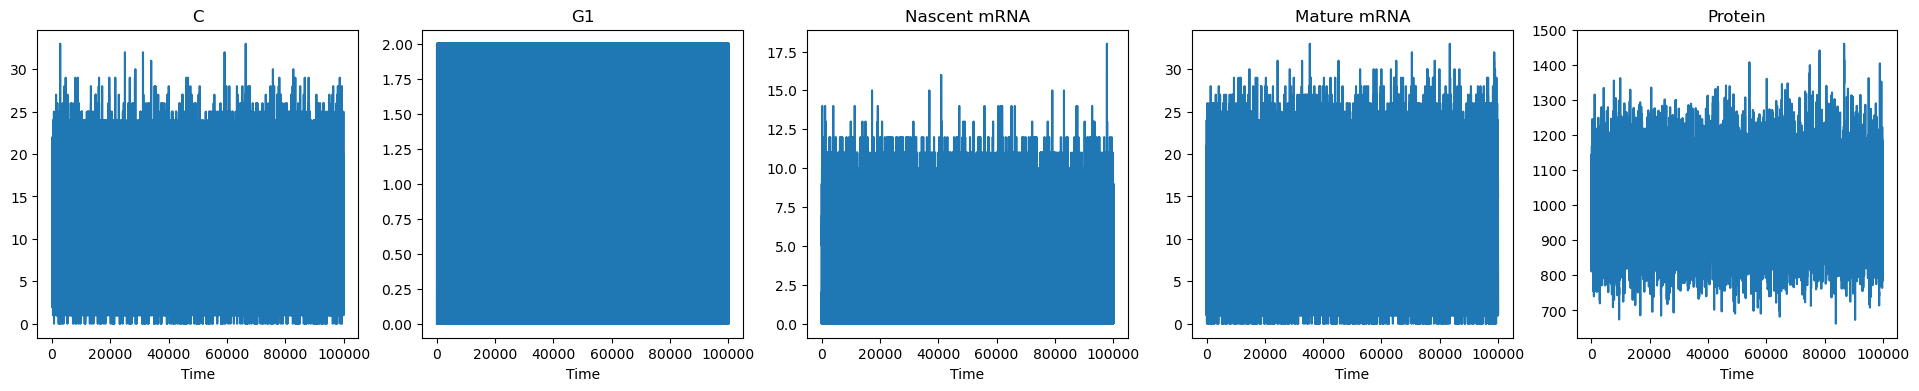

In [16]:
#Plot the results
plt.figure(figsize = (24, 4))
plt.subplot(151)
plt.title("C")
plt.plot(timepoints, results["C"])
plt.xlabel("Time")
plt.subplot(152)
plt.title("G1")
plt.plot(timepoints, results["G1"])
plt.xlabel("Time")
plt.subplot(153)
plt.title("Nascent mRNA")
plt.plot(timepoints, results["U"])
plt.xlabel("Time")
plt.subplot(154)
plt.title("Mature mRNA")
plt.plot(timepoints, results["S"])
plt.xlabel("Time")
plt.subplot(155)
plt.plot(timepoints, results["P"])
plt.xlabel("Time")
plt.title("Protein");

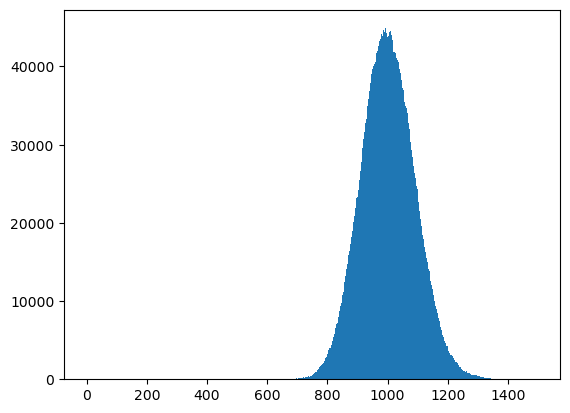

In [17]:
plt.hist(results["P"],bins=np.arange(1500)-0.5);

In [23]:
eta_gg = results["G1"].var()/results["G1"].mean()**2
eta_uu = results["U"].var()/results["U"].mean()**2
eta_ss = results["S"].var()/results["S"].mean()**2
eta_cc = results["C"].var()/results["C"].mean()**2
eta_pp = results["P"].var()/results["P"].mean()**2

eta_gu = np.cov(results["G1"],results["U"])[0,1]/results["G1"].mean()/results["U"].mean()
eta_gs = np.cov(results["G1"],results["S"])[0,1]/results["G1"].mean()/results["S"].mean()
eta_gc = np.cov(results["G1"],results["C"])[0,1]/results["G1"].mean()/results["C"].mean()
eta_gp = np.cov(results["G1"],results["P"])[0,1]/results["G1"].mean()/results["P"].mean()
eta_us = np.cov(results["U"],results["S"])[0,1]/results["U"].mean()/results["S"].mean()
eta_uc = np.cov(results["U"],results["C"])[0,1]/results["U"].mean()/results["C"].mean()
eta_up = np.cov(results["U"],results["P"])[0,1]/results["U"].mean()/results["P"].mean()
eta_sc = np.cov(results["S"],results["C"])[0,1]/results["G1"].mean()/results["C"].mean()
eta_sp = np.cov(results["S"],results["P"])[0,1]/results["S"].mean()/results["P"].mean()
eta_cp = np.cov(results["C"],results["P"])[0,1]/results["C"].mean()/results["P"].mean()

In [24]:
eta_gg,koff/(kon+koff)/results["G1"].mean()

(0.49988595877717407, 0.5000910165650149)

In [25]:
eta_gu,beta/(beta+kon+koff)*eta_gg

(0.1666711349152445, 0.16662865292572468)

In [26]:
eta_cp, eta_pp-1/results["P"].mean()

(0.007092824859429376, 0.007098942056547361)

# Poisson model

In [12]:
# Constitutive model likelihood function.
def PMF_Poisson_2sp(mx, params, t=np.inf):
    K_avg, beta, gamma = params
    mu_N, mu_M = K_avg/beta, K_avg/gamma
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')
    
    return poisson.pmf(X_N, mu_N)*poisson.pmf(X_M, mu_M)
    
def ll_Poisson(phi, mx, data):
    # Get parameters
    k, b, g = phi
    K_avg = 1/k-1
    beta = 1/b-1
    gamma = 1/g-1
    params = [K_avg, beta, gamma]
    
    # Compute PMF
    Pss = PMF_Poisson_2sp(mx, params)    

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result

In [13]:
d_N, d_M = data
mx = [np.max(d_N)+10,np.max(d_M)+10]

# Parameter bounds
epsilon = 1e-4
x_min, x_max = epsilon, 1-epsilon
        
# Define log likelihood
logl_op = LogLike(mx, data, ll_Poisson)
def logl_fun(phi):
    return logl_op(phi)

# Define PyMC model
model = pm.Model()
with model:
    # Priors
    k_ = pm.Uniform('x', lower=x_min, upper=x_max) 
    b_ = pm.Uniform('z', lower=x_min, upper=x_max)
    g_ = pm.Uniform('q', lower=x_min, upper=x_max)

    phi = tt.as_tensor_variable([k_, b_, g_])

    # Likelihood
    pm.Potential('likelihood', logl_fun(phi))
    
# Run PyMC model
#start_time = ti.time()
with model:
    trace = pm.sample(draws=1000)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Apply node that caused the error: LogLike(MakeVector{dtype='float64'}.0)
Toposort index: 4
Inputs types: [TensorType(float64, shape=(3,))]
Inputs shapes: [(3,)]
Inputs strides: [(8,)]
Inputs values: [array([0.5, 0.5, 0.5])]
Outputs clients: [['output']]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
    result = self._run_cell(
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
    result = runner(coro)
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_21159/1312715474.py", line 24, in <module>
    pm.Potential('likelihood', logl_fun(phi))
  File "/tmp/ipykernel_21159/1312715474.py", line 11, in logl_fun
    return logl_op(phi)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
def run_MC_Poisson(data):
    # meshgrid bounds
    d_N, d_M = data
    mx = [np.max(d_N)+10,np.max(d_M)+10]
    
    # Parameter bounds
    epsilon = 1e-4
    x_min, x_max = epsilon, 1-epsilon
            
    # Define log likelihood
    logl_op = LogLike(mx, data, ll_Poisson)
    def logl_fun(phi):
        return logl_op(phi)
    
    # Define PyMC3 model
    model = pm.Model()
    with model:
        # Priors
        k_ = pm.Uniform('x', lower=x_min, upper=x_max) 
        b_ = pm.Uniform('z', lower=x_min, upper=x_max)
        g_ = pm.Uniform('q', lower=x_min, upper=x_max)
    
        phi = tt.as_tensor_variable([k_, b_, g_])
    
        # Likelihood
        pm.Potential('likelihood', logl_fun(phi))
        
    # Run PyMC model
    #start_time = ti.time()
    with model:
        trace = pm.sample(draws=1000)
    return trace

# Bursty model

In [3]:
# Mixture model likelihood function.
def PMF_bursty_2sp(mx, params, t=np.inf):
    """
    mx: sequence of ints
        Grid shapes
    """
    k, b, beta, gamma = params 
    
    # Get generating function argument
    z = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        z.append(np.exp(-2j*np.pi*l/mx[i]))
    Z = np.meshgrid(*[z_ for z_ in z], indexing='ij') # Z is a list of ndarray with shape half
    for i in range(len(mx)): # i indices the dimension of X
        Z[i] = Z[i].flatten()
    
    # Get generating function
    gf = np.exp(- (a/kappa)*np.log(1 - theta*(g[0]/beta + g[1]/gamma)))
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss

$$G(u_0,u_1,z_1,z_2,t)=u_0 \exp(\int_0^t k_{on} (\frac{k_{off}}{k_{off} + \alpha(Z_1-1)} - 1) ds)$$

In [2]:
# ODE for 2 species CIR model
def f_2sp(q, t, c0, c1, params):
    beta_0, beta_1, a, kappa, theta = params
    result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
    return result


# Vectorized RK4 implementation for 2 species CIR model
def RK4_2sp(q, f, t, c0, c1, step_size, param):
    j1 = f(q, t, c0, c1, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  
    
    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
    return q_new


# Get 2 species CIR generating function using ODE method
def GF_CIR_2sp(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
     
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    
    # Solve ODE using RK4 method 
    for i in range(0, num_tsteps):
        t = i*dt
        q[:,i+1] = RK4_2sp(q[:,i], f_2sp, t, c0, c1, dt, params)
        
    integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp((a*theta/kappa)*integral)               # get generating function
    return gf


# Get Pss for 2 species CIR model via ODE method
def PMF_CIR_2sp(mx, params, t=np.inf):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_CIR_2sp(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss

In [ ]:
def ll_CIR(phi, mx, data):
    # Get parameters
    x, y, z, q = phi
    beta = 1/z-1
    gamma = 1/q-1
    K_avg = 1
    
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_CIR_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result

In [4]:
# Log likelihood of CIR model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_CIR(phi, mx, data):
    # Get parameters
    x, y, z, q = phi
    beta = 1/z-1
    gamma = 1/q-1
    K_avg = 1
    
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_CIR_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result